# Import library

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import functools

## Random seed

In [72]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [73]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Parameters

In [74]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [75]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

    Args:
        w: the beamforming vectors
    """
    total_norm = 0
    for i in range(number_of_users):
        total_norm += np.linalg.norm(w[i])
    for i in range(number_of_users):
        w[i] = w[i] / total_norm
    return w

def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [(np.random.randn(N, 1) + 1j * np.random.randn(N, 1)) for i in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    # realPart = np.random.randn(1, Nris)
    # imagPart = np.random.randn(1, Nris)
    # theta = realPart + 1j * imagPart
    # theta = np.exp(1j * np.angle(theta))  # Normalize theta to the unit circle
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

In [76]:
# Reseed
# np.random.seed(RANDOM_SEED)

# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

# Objective Function

In [77]:
def secrecy_rate_objective_function(theta, w):
    secrecy_rate = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)
    return secrecy_rate

In [78]:
print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

[[ 0.88048122+0.47408102j  0.10675779-0.99428506j -0.94121722+0.33780192j
  -0.51552239-0.85687611j  0.98551347-0.16959717j  0.1734521 -0.98484231j
   0.05972855-0.99821466j -0.82186107+0.56968797j -0.64812937+0.76153025j
   0.94798661+0.31831021j -0.58631416-0.81008376j  0.30854288-0.95121044j
  -0.88320766-0.46898212j -0.36293885+0.93181296j -0.8274319 -0.56156608j
  -0.90636523+0.42249504j  0.95027299-0.31141812j  0.82084652+0.57114883j
  -0.89074293-0.45450746j -0.68946858+0.72431559j  0.95427824-0.2989198j
   0.98565906+0.16874896j  0.82615517-0.56344267j -0.45260546+0.89171088j
  -0.3844826 +0.92313224j -0.97945512+0.20166227j -0.83626362-0.54832761j
   0.26845845+0.96329127j  0.87334229+0.48710702j -0.93345363-0.3586981j
  -0.70376125-0.71043656j  0.68661103+0.72702496j]]
distance between Alice and the receivers:  [np.float64(8.597260577730964), np.float64(7.704507320858385), np.float64(9.344025672091696), np.float64(5.531459234567628)]
distance between Alice and the eavesdroppe

# Method

## Gradient Descent for Maximization (GD)

In [79]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    

    #Precalculation 
    for k in range (number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range (number_of_users):
        grad = np.zeros((N, 1))
        #print("grad_shape =", grad.shape)
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                #print("num_grad_C_e_max_to_w_k", num_grad_C_e_max_to_w_k.shape)
                #print("den_grad_C_e_max_to_w_k", den_grad_C_e_max_to_w_k.shape)
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta(theta, w, epsilon=1e-3):
    grad_theta = []
    for i in range(Nris):
        theta_plus = deepcopy(theta)
        theta_plus[0, i] += epsilon + epsilon*1j
        theta_minus = deepcopy(theta)
        theta_minus[0, i] -= epsilon + epsilon*1j
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w))/(2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta).reshape(1, Nris)



def gradient_descent_update(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(w_new[i]) ** 2
    for i in range (number_of_users):
        w_new[i] = w_new[i] / np.sqrt(total_norm)
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new



In [80]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta()
w_GD = generate_random_beamforming_vectors()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate)
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    # print(new_secrecy_rate)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

print(GD_results)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))

Initial Secrecy Rate GD: [[1.82372337]]
Converged
[array([[1.99173459]]), array([[9.59946581]]), array([[10.55667421]]), array([[11.39722253]]), array([[12.1381016]]), array([[12.78368189]]), array([[13.33802886]]), array([[13.8070376]]), array([[14.1988159]]), array([[14.52310222]]), array([[14.78987793]]), array([[15.00820114]]), array([[15.18581287]]), array([[15.32916556]]), array([[15.44359737]]), array([[15.53353027]]), array([[15.60264927]]), array([[15.65405173]]), array([[15.6903672]]), array([[15.71385158]]), array([[15.72646009]]), array([[15.72988698]])]
Final Secrecy Rate GD: [[15.72988698]]


## Particle Swarm Optimization (PSO)

In [81]:
# Helper functions for the optimization algorithm

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)

In [82]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()
    self.best_theta = deepcopy(self.theta)
    self.best_w = deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    self.velocity_theta = inertia * self.velocity_theta + c1 * np.random.rand() * (self.best_theta - self.theta) + c2 * np.random.rand() * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * np.random.rand() * (self.best_w[i] - self.w[i]) + c2 * np.random.rand() * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.theta = np.exp(1j * np.angle(self.theta))
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(self.w[i])
    for i in range(number_of_users):
        self.w[i] = self.w[i] / total_norm


  def update_best(self):
    current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = current_secrecy_rate
      self.best_theta = deepcopy(self.theta)
      self.best_w = deepcopy(self.w)

In [83]:
def dynamic_inertia(i, max_iter, inertia_max, inertia_min):
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [89]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for iteration in range(max_iter):
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = deepcopy(particle.best_theta)
        global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)

  return results_secrecy_rate

In [90]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 500
num_particles = 100
w_min = 0.4
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

Initial Secrecy Rate PSO: [[4.11239275]]
[array([[4.11239275]]), array([[4.81958395]]), array([[4.85102709]]), array([[5.05927965]]), array([[5.30546361]]), array([[5.50653317]]), array([[5.72400033]]), array([[6.3016448]]), array([[6.50640108]]), array([[6.61304042]]), array([[7.21670068]]), array([[8.31242193]]), array([[9.50813333]]), array([[9.90659721]]), array([[10.01104218]]), array([[10.36236072]]), array([[10.41659097]]), array([[10.49620679]]), array([[10.51015962]]), array([[10.57543846]]), array([[10.58698621]]), array([[10.61530085]]), array([[10.64035454]]), array([[10.68451533]]), array([[10.779751]]), array([[10.8767702]]), array([[10.97222287]]), array([[10.98817119]]), array([[10.99152872]]), array([[11.01506474]]), array([[11.0207781]]), array([[11.05099965]]), array([[11.06221126]]), array([[11.08807892]]), array([[11.09986905]]), array([[11.10996641]]), array([[11.10996641]]), array([[11.11243282]]), array([[11.11689774]]), array([[11.11712067]]), array([[11.121990

## Genetic Algorithm (GA)

In [515]:
class Individual:
    def __init__(self):
        self.theta = generate_random_theta()
        self.w = generate_random_beamforming_vectors()
        self.value = secrecy_rate_objective_function(self.theta, self.w) 
        #IMPORTANT: VALUE SHOULD BE UPDATED EVERY TIME THETA OR W IS CHANGED OR INITIALIZED
        
def compare(individual1, individual2):
    if individual1.value.item() < individual2.value.item():
        return 1
    else:
        return -1

def rank_population(population):
    sorted(population, key=functools.cmp_to_key(compare))
    return population

def select_parents(population, parent1_index):
    parent2_index = np.random.randint(0, population_size)
    while parent2_index == parent1_index:
        parent2_index = np.random.randint(0, population_size)
    return population[parent2_index]

def crossover(parent1, parent2):
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    child_theta = (theta1 + theta2) / 2
    child_w = [(w1[i] + w2[i]) / 2 for i in range (number_of_users)]
    new_individual = Individual()
    new_individual.theta = child_theta
    new_individual.w = child_w
    new_individual.value = secrecy_rate_objective_function(new_individual.theta, new_individual.w)
    return new_individual

def mutate(individual):
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(Nris)
        new_number = np.random.randn() + np.random.randn() * 1j
        individual.theta[0, mutation_index] = np.exp(1j * np.angle(new_number))
        individual.value = secrecy_rate_objective_function(individual.theta, individual.w)

    '''
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(len(individual.w))
        individual.w[mutation_index] = generate_random_beamforming_vectors()
        individual.value = secrecy_rate_objective_function(individual.theta, individual.w)
    '''
    return individual
        
def genetic_algorithm():
    population = [Individual() for _ in range(population_size)]
    best_individual = copy.deepcopy(population[0])
    best_fitness = copy.deepcopy(secrecy_rate_objective_function(population[0].theta, population[0].w))

    for individual in population:
        individual_fitness = secrecy_rate_objective_function(individual.theta, individual.w)
        if (individual_fitness > best_fitness):
            best_fitness = copy.deepcopy(individual_fitness)
            best_individual = copy.deepcopy(individual)

    GA_results.append(best_fitness)

    for generation in range(num_generations):
        new_population = copy.deepcopy(population)

        #Crossover State
        for i in range (population_size):
            if np.random.rand() > crossover_rate:
                continue
            parent2 = select_parents(population, i)
            child = crossover(population[i], parent2)
            new_population.append(copy.deepcopy(child))

        #Mutation State
        for i in range (len(new_population)):
            new_population[i] = mutate(new_population[i])
        
        #Selection State
        population = rank_population(new_population)
        print("after ranked")
        for individual in new_population:
            print(individual.value, end=" ")
        
        while(len(new_population) > population_size):
            new_population.pop()

        population = new_population
        best_individual = copy.deepcopy(population[0])
        best_fitness = copy.deepcopy(population[0].value)

        print(f"Generation {generation + 1}/{num_generations}, Best Fitness: {best_fitness}")
        
        GA_results.append(best_fitness)

    return best_individual


# Genetic Algorithm parameters
population_size = 100
num_generations = 500
crossover_rate = 0.85
mutation_rate = 0.3

GA_results = []
GA_results.append(secrecy_rate_objective_function(theta_init, w_init))

In [516]:
# Run the genetic algorithm
best_individual = genetic_algorithm()
print("Best Individual:", best_individual.theta, best_individual.w)
print("Best Fitness:", secrecy_rate_objective_function(best_individual.theta, best_individual.w))

after ranked
[[0.55403977]] [[1.67187407]] [[1.25944382]] [[0.66479778]] [[1.22894978]] [[0.79780059]] [[1.28281798]] [[2.22874385]] [[1.3355566]] [[1.03973513]] [[2.28733219]] [[0.82683766]] [[2.48031161]] [[2.03812961]] [[1.16019022]] [[1.90472485]] [[1.41588353]] [[0.96825569]] [[1.99463202]] [[2.46590878]] [[1.54768564]] [[2.03416301]] [[2.25550117]] [[1.77854416]] [[2.0606531]] [[1.27667893]] [[1.77222918]] [[0.72868456]] [[0.92171906]] [[1.80149507]] [[2.74009207]] [[2.21480882]] [[1.06429537]] [[0.59226813]] [[1.39783751]] [[0.48648601]] [[2.90492096]] [[2.87183215]] [[1.1064863]] [[2.11460745]] [[2.76460437]] [[2.91217001]] [[3.53092072]] [[0.61413434]] [[1.51229529]] [[1.79453996]] [[1.79300221]] [[2.67381135]] [[1.50870186]] [[1.06846744]] [[1.85238451]] [[1.36562345]] [[1.49277207]] [[1.90917219]] [[1.61944595]] [[0.94646272]] [[1.66987686]] [[0.87396317]] [[1.41258186]] [[1.88729373]] [[0.47932017]] [[2.06630361]] [[2.17829912]] [[2.0053339]] [[1.25536602]] [[1.73624564]] [

KeyboardInterrupt: 

## Combination of PSO and GD

In [455]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, w_max, w_min, c1, c2):
    particles = [Particle() for _ in range(number_of_particles)]
    gbest_theta = copy.deepcopy(particles[0].theta)
    gbest_w = copy.deepcopy(particles[0].w)
    gbest_value = copy.deepcopy(particles[0].pbest_value)
    
    for individual in particles:
        if (individual.pbest_value > gbest_value):
            gbest_value = copy.deepcopy(individual.pbest_value)
            gbest_theta = copy.deepcopy(individual.pbest_theta)
            gbest_w = copy.deepcopy(individual.pbest_w)
    
    for pso_iteration in range(max_pso_iter):
        E_t = float((max_iter - pso_iteration - 1)/max_iter)
        inertia = w_min + (w_max - w_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)

        for i in range(number_of_particles):
            for gd_iteration in range(max_gd_iter):
                particles[i].w, particles[i].theta = gradient_descent_update(particles[i].w, particles[i].theta, learning_rate)
            particles[i].update_velocity_theta(gbest_theta, inertia, c1, c2)
            particles[i].update_position_theta()
            particles[i].update_velocity_w(gbest_w, inertia, c1, c2)
            particles[i].update_position_w()
            
            fitness_value = secrecy_rate_objective_function(particles[i].theta, particles[i].w)
            if fitness_value > particles[i].pbest_value:
                particles[i].pbest_value = copy.deepcopy(fitness_value)
                particles[i].pbest_theta = copy.deepcopy(particles[i].theta)
                particles[i].pbest_w = copy.deepcopy(particles[i].w)
            
            if fitness_value > gbest_value:
                gbest_value = copy.deepcopy(fitness_value)
                gbest_theta = copy.deepcopy(particles[i].theta)
                gbest_w = copy.deepcopy(particles[i].w)
        print(gbest_value)
        PSO_GD_results.append(gbest_value)

In [456]:
max_pso_iter = 500
max_gd_iter = 100
number_of_particles = 100
w_max = 0.9
w_min = 0.5
c1 = 20
c2 = 10
PSO_GD_results = []
PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, w_max, w_min, c1, c2)
print(PSO_GD_results)
    
    

KeyboardInterrupt: 

# Plot diagram

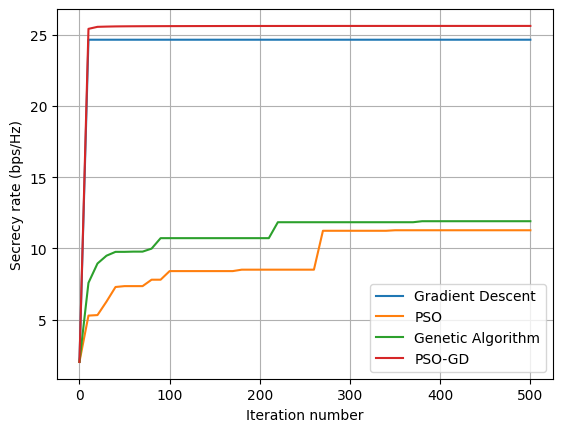

In [35]:
iterations = range(0, num_cycles+10, 10)

# Plotting the data
plt.plot(iterations, GD_results, label='Gradient Descent')
plt.plot(iterations, PSO_results, label='PSO')
plt.plot(iterations, GA_results[0:len(iterations)], label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results, label='PSO-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [36]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: [24.6548294]
Best Secrecy Rate PSO: [11.27448635]
Best Secrecy Rate GA: [17.00556469]
Best Secrecy Rate PSO-GD: [25.62364522]
